In [1]:
import sys, os, time
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from gensim.models.wrappers import FastText
import gensim
import fastText
torch.set_printoptions(linewidth=120)
np.set_printoptions(linewidth=120, suppress=True)

/home/fleeb/anaconda3/envs/py36/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
#model = gensim.models.KeyedVectors.load_word2vec_format('/mnt/c/Users/anwan/Downloads/wiki-news-300d-1M.vec/wiki-news-300d-1M.vec')

# model = gensim.models.KeyedVectors.load_word2vec_format('../../fastText/wiki.en.vec')
lang = fastText.load_model('../../fastText/wiki.en.bin')

In [19]:
oie = Aristo('../data/openbook_tuples.tsv')
len(oie)

3793

In [20]:
otable = {}


In [21]:
oie[1]

['conductor', 'is vehicle for', 'flow']

In [8]:
lang.get_word_vector('testaklgja').shape

(300,)

In [42]:
def cosd(x,y):
    if x.ndimension() == 1:
        x = x.unsqueeze(0)
    if y.ndimension() == 1:
        y = y.unsqueeze(0)
    x = F.normalize(x, 2, -1)
    y = F.normalize(y, 2, -1)
    return -x @ y.transpose(-1,-2)/2+.5
def l2(x,y):
    if x.ndimension() == 1:
        x = x.unsqueeze(0)
    if y.ndimension() == 1:
        y = y.unsqueeze(0)
    x = x.unsqueeze(-2)
    y = y.unsqueeze(-3)
    return (x-y).pow(2).mean(-1)

In [81]:
words = ['king', 'queen', 'man', 'woman', 'table', 'doctor', 'tiger', 'france', 'china']
vecs = []
for w in words:
    vecs.append(lang.get_word_vector(w))
vecs = torch.from_numpy(np.stack(vecs))
vecs.shape

torch.Size([9, 300])

In [88]:
dataset = Aristo()
len(dataset)

282594

In [96]:
tbl = torch.load('../../old/table.pth.tar')
tbl.keys()

dict_keys(['rows', 'table', 'completed'])

In [22]:
dataset = oie

In [23]:
ftable = {}
for i, tpl in enumerate(oie):
    for x in tpl:
        
        if x not in ftable:
            ftable[x] = lang.get_word_vector(x)
    if i % 1000 == 0:
        print('{}/{}'.format(i+1,len(dataset)))
len(ftable)

1/3793
1001/3793
2001/3793
3001/3793


2886

In [24]:
len(ftable)

2886

In [25]:
elements = []
vecs = []

for k,v in ftable.items():
    elements.append(k)
    vecs.append(v)
    
vecs = np.stack(vecs)
len(elements), vecs.shape

(2886, (2886, 300))

In [26]:
# torch.save({'elements':elements,'vecs':vecs,'rows':dataset.tuples}, '../oie_table.pth.tar')

In [86]:
v = torch.from_numpy(lang.get_word_vector('chill')).unsqueeze(0)
v.shape

torch.Size([1, 300])

In [87]:
print(cosd(v,vecs).numpy())

[[0.43359974 0.43285793 0.36233115 0.43297434 0.40758592 0.41534483 0.40045962 0.45124558 0.46199214]]


In [18]:
class Aristo(Dataset):
    def __init__(self, aristo_path='../../aristo.txt'):
        super().__init__()
        with open(aristo_path, 'r') as f:
            self.tuples = []
            for row in f.readlines():
                row = row[:-1].split('\t')
                l = []
                for x in row:
                    if x[0] == ' ':
                        x = x[1:]
                    if x[-1] == ' ':
                        x = x[:-1]
                    l.append(x)
                self.tuples.append(l)
#             self.tuples = [row[:-1].split('\t') for row in f.readlines()]
            
    def __len__(self):
        return len(self.tuples)
    
    def __getitem__(self, idx):
        return self.tuples[idx]

class Choose2(Dataset): # unordered, no repeats
    def __init__(self, dataset):
        self.dataset = dataset
            
    def __getitem__(self, idx):
        
        i = int(1+np.sqrt(1+8*idx))//2
        j = idx % i
        
        return self.dataset[i], self.dataset[j]
        
        A = self.tuples[i]
        B = self.tuples[j]
        
        match = sum([A[0]==B[0], A[1]==B[1], A[2]==B[2], A[0]==B[2], A[2]==B[0]])
        
        return A, B, match
    
    def __len__(self,):
        return len(self.dataset)*(len(self.dataset)-1)//2
    
class Tokens2Vec(Dataset):
    def __init__(self, source, lang_model, merge_type='avg'):
        self.source = source
        self.lang_model = lang_model
        self.merge_type = merge_type
        
    def __len__(self):
        return len(self.source)
    
    def __getitem__(self, idx):
        toks = self.source[idx]
        
        vecs = [torch.from_numpy(self.lang_model(tok)).float() for tok in toks]
        
        if self.merge_type == 'avg':
            x = sum(vecs)/len(vecs)
        elif self.merge_type == 'cat':
            x = torch.cat(vecs,-1)
        else:
            raise Exception('unknown mergy type: {}'.format(self.merge_type))
            
        return x

In [6]:
# dataset = Aristo()
rawdataset = Aristo()
dataset = Tokens2Vec(rawdataset, lang.get_word_vector, merge_type='avg')
len(dataset)

NameError: name 'lang' is not defined

In [92]:
dataset[10].shape

torch.Size([300])

In [94]:
rawdataset[10], rawdataset[11]

(['aardvark', 'has-part', 'head'], ['aardvark', 'has-part', 'nucleus'])

In [ ]:
dataset[10]

In [58]:
dataset = AristoMatches()
len(dataset)

39929543121

In [55]:
counts = [0]*6
for

(['aardvark', 'has-part', 'head\n'], ['aardvark', 'has-part', 'brain\n'], 2)

In [2]:
# model = fastText.load_model('../fastText/data/dbpedia.bin')
model = fastText.load_model('/mnt/c/Users/anwan/Downloads/wiki.en/wiki.en.bin')

In [8]:
words = ['king', 'queen', 'man', 'woman', 'table', 'computer', 'tailor', 'doctor']
vecs = []
for w in words:
    vecs.append(model.get_vector(w))
vecs = torch.from_numpy(np.stack(vecs))
vecs.shape

torch.Size([8, 300])

In [9]:
vecs

tensor([[-0.0573,  0.0025, -0.0059,  ...,  0.0319, -0.0145, -0.0152],
        [-0.0283, -0.0074,  0.0025,  ...,  0.0322,  0.0274,  0.0430],
        [-0.0205,  0.0024,  0.0279,  ..., -0.0092, -0.0140, -0.0354],
        ...,
        [-0.0348, -0.0069, -0.0144,  ..., -0.0124,  0.0261, -0.0008],
        [ 0.0199,  0.0010, -0.0103,  ..., -0.0087, -0.0258, -0.0529],
        [-0.0212, -0.0120,  0.0110,  ...,  0.0075,  0.0089, -0.0321]])

In [40]:
dist(vecs[0], vecs[2])

tensor([[1.]])

In [37]:
dist(vecs[1], vecs[3])

tensor([[0.5240]])

In [38]:
dist(vecs[3]+vecs[0]-vecs[1], vecs[2])

tensor([[0.7801]])

In [32]:
def dist(x,y):
    if x.ndimension() == 1:
        x = x.unsqueeze(0)
    if y.ndimension() == 1:
        y = y.unsqueeze(0)
    x = F.normalize(x, 2, -1)
    y = F.normalize(y, 2, -1)
    return x @ y.transpose(-1,-2)
# def dist(x,y):
#     if x.ndimension() == 1:
#         x = x.unsqueeze(0)
#     if y.ndimension() == 1:
#         y = y.unsqueeze(0)
#     x = x.unsqueeze(-2)
#     y = y.unsqueeze(-3)
#     return (x-y).pow(2).mean(-1)

<IPython.core.display.Javascript object>


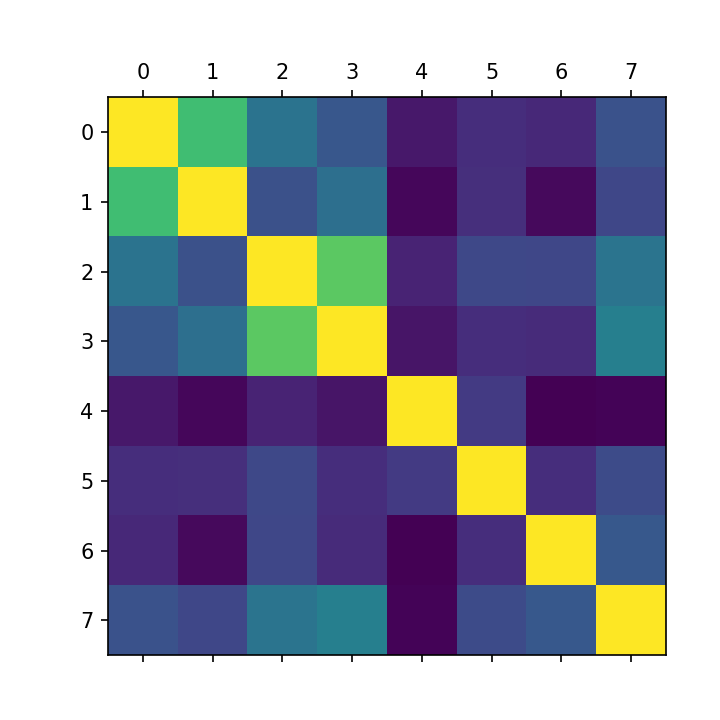

In [33]:
plt.matshow(dist(vecs, vecs).numpy())

In [33]:
np.sum((x-y)**2)

29.870918

In [34]:
np.sum((x-z)**2)

1.7082936

In [35]:
np.sum((y-z)**2)

40.071594